## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-03-30 22:29:18--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.242.110
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.242.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  83.8MB/s    in 3.9s    

2020-03-30 22:29:22 (81.9 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [18]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [15]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
  (dropout5): Dropout(p=0.4)
  (dropout6): Dropout(p=0.4)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm1d(800, eps=1e-05, m

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [13]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop

data_transform = transforms.Compose([Rescale((250, 250)), 
                                           RandomCrop((224, 224)), 
                                           Normalize(), 
                                           ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [11]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [25]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [20]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

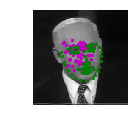

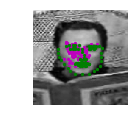

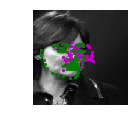

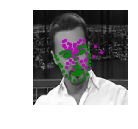

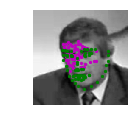

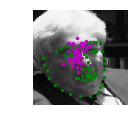

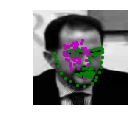

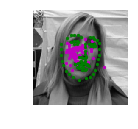

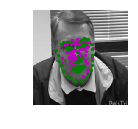

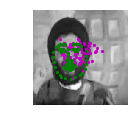

In [21]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [23]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [25]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 40 == 39:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/40))
                running_loss = 0.0

    print('Finished Training')


In [26]:
# train your network
n_epochs = 30 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 80, Avg. Loss: 0.22291336357593536
Epoch: 1, Batch: 120, Avg. Loss: 0.1520233888179064
Epoch: 1, Batch: 160, Avg. Loss: 0.1469395723193884
Epoch: 1, Batch: 200, Avg. Loss: 0.14197948537766933
Epoch: 1, Batch: 240, Avg. Loss: 0.1284899951890111
Epoch: 1, Batch: 280, Avg. Loss: 0.11032972298562527
Epoch: 1, Batch: 320, Avg. Loss: 0.09943630648776888


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 40, Avg. Loss: 0.09237786680459976
Epoch: 2, Batch: 80, Avg. Loss: 0.08527919854968787
Epoch: 2, Batch: 120, Avg. Loss: 0.08385034687817097
Epoch: 2, Batch: 160, Avg. Loss: 0.07102367505431176
Epoch: 2, Batch: 200, Avg. Loss: 0.07201884184032678
Epoch: 2, Batch: 240, Avg. Loss: 0.06062698503956199
Epoch: 2, Batch: 280, Avg. Loss: 0.06563878823071718
Epoch: 2, Batch: 320, Avg. Loss: 0.0573982116766274


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 40, Avg. Loss: 0.06443843003362418
Epoch: 3, Batch: 80, Avg. Loss: 0.06216660719364882
Epoch: 3, Batch: 120, Avg. Loss: 0.06313792420551181
Epoch: 3, Batch: 160, Avg. Loss: 0.05433802464976907
Epoch: 3, Batch: 200, Avg. Loss: 0.04887754721567035
Epoch: 3, Batch: 240, Avg. Loss: 0.05423735757358372
Epoch: 3, Batch: 280, Avg. Loss: 0.048319835867732766
Epoch: 3, Batch: 320, Avg. Loss: 0.050682311737909914


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 40, Avg. Loss: 0.04493185267783702
Epoch: 4, Batch: 120, Avg. Loss: 0.049982527969405055
Epoch: 4, Batch: 160, Avg. Loss: 0.04380986248143017
Epoch: 4, Batch: 200, Avg. Loss: 0.041587493289262055
Epoch: 4, Batch: 240, Avg. Loss: 0.04910201090388
Epoch: 4, Batch: 280, Avg. Loss: 0.04390098568983376
Epoch: 4, Batch: 320, Avg. Loss: 0.041905444022268055


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 40, Avg. Loss: 0.04716762150637806
Epoch: 5, Batch: 80, Avg. Loss: 0.04349886728450656
Epoch: 5, Batch: 120, Avg. Loss: 0.044295934634283184
Epoch: 5, Batch: 160, Avg. Loss: 0.04164889194071293
Epoch: 5, Batch: 200, Avg. Loss: 0.04123953059315681
Epoch: 5, Batch: 240, Avg. Loss: 0.03863881705328822
Epoch: 5, Batch: 280, Avg. Loss: 0.04063218482770026
Epoch: 5, Batch: 320, Avg. Loss: 0.033305185148492455


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 40, Avg. Loss: 0.044037449778988956
Epoch: 6, Batch: 80, Avg. Loss: 0.03848700919188559
Epoch: 6, Batch: 120, Avg. Loss: 0.04062159336172044
Epoch: 6, Batch: 160, Avg. Loss: 0.03889556350186467
Epoch: 6, Batch: 200, Avg. Loss: 0.04262584373354912
Epoch: 6, Batch: 240, Avg. Loss: 0.03997526406310499
Epoch: 6, Batch: 280, Avg. Loss: 0.03557565161027014
Epoch: 6, Batch: 320, Avg. Loss: 0.035358717967756095


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 40, Avg. Loss: 0.061501875426620244
Epoch: 7, Batch: 80, Avg. Loss: 0.06293940730392933
Epoch: 7, Batch: 120, Avg. Loss: 0.049158058129251
Epoch: 7, Batch: 160, Avg. Loss: 0.046185886347666384
Epoch: 7, Batch: 200, Avg. Loss: 0.04353500534780323
Epoch: 7, Batch: 240, Avg. Loss: 0.038729044841602445
Epoch: 7, Batch: 280, Avg. Loss: 0.04157478795386851
Epoch: 7, Batch: 320, Avg. Loss: 0.04282402065582573


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 40, Avg. Loss: 0.05838275565765798
Epoch: 8, Batch: 80, Avg. Loss: 0.044825491355732085
Epoch: 8, Batch: 120, Avg. Loss: 0.049654496787115934
Epoch: 8, Batch: 160, Avg. Loss: 0.04483160995878279
Epoch: 8, Batch: 200, Avg. Loss: 0.04029187448322773
Epoch: 8, Batch: 240, Avg. Loss: 0.039198623644188045
Epoch: 8, Batch: 280, Avg. Loss: 0.03973663719370961
Epoch: 8, Batch: 320, Avg. Loss: 0.03757969932630658


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 40, Avg. Loss: 0.041145101701840756
Epoch: 9, Batch: 80, Avg. Loss: 0.03798229065723717
Epoch: 9, Batch: 120, Avg. Loss: 0.03659237779211253
Epoch: 9, Batch: 160, Avg. Loss: 0.03331003081984818
Epoch: 9, Batch: 200, Avg. Loss: 0.039043577900156376
Epoch: 9, Batch: 240, Avg. Loss: 0.035265321377664804
Epoch: 9, Batch: 280, Avg. Loss: 0.0350898954551667
Epoch: 9, Batch: 320, Avg. Loss: 0.03731550807133317


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 40, Avg. Loss: 0.04014102751389146
Epoch: 10, Batch: 80, Avg. Loss: 0.037972974684089424
Epoch: 10, Batch: 120, Avg. Loss: 0.035722632566466926
Epoch: 10, Batch: 160, Avg. Loss: 0.03682452088687569
Epoch: 10, Batch: 200, Avg. Loss: 0.03813547897152603
Epoch: 10, Batch: 240, Avg. Loss: 0.03612311061006039
Epoch: 10, Batch: 280, Avg. Loss: 0.035956365847960116
Epoch: 10, Batch: 320, Avg. Loss: 0.0359357324661687


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 40, Avg. Loss: 0.036618996132165196
Epoch: 11, Batch: 80, Avg. Loss: 0.031616184813901785
Epoch: 11, Batch: 120, Avg. Loss: 0.031015742546878756
Epoch: 11, Batch: 160, Avg. Loss: 0.02931969319470227
Epoch: 11, Batch: 200, Avg. Loss: 0.03262114147655666
Epoch: 11, Batch: 240, Avg. Loss: 0.03678894615732133
Epoch: 11, Batch: 280, Avg. Loss: 0.027694761008024215
Epoch: 11, Batch: 320, Avg. Loss: 0.032893444504588844


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 40, Avg. Loss: 0.05619350993074477
Epoch: 12, Batch: 80, Avg. Loss: 0.04916099766269326
Epoch: 12, Batch: 120, Avg. Loss: 0.04390555857680738
Epoch: 12, Batch: 160, Avg. Loss: 0.04107905067503452
Epoch: 12, Batch: 200, Avg. Loss: 0.04096426879987121
Epoch: 12, Batch: 240, Avg. Loss: 0.040811519930139185
Epoch: 12, Batch: 280, Avg. Loss: 0.034255389124155045
Epoch: 12, Batch: 320, Avg. Loss: 0.03680364852771163


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 40, Avg. Loss: 0.060297973453998566
Epoch: 13, Batch: 80, Avg. Loss: 0.042524014692753555
Epoch: 13, Batch: 120, Avg. Loss: 0.038377064978703856
Epoch: 13, Batch: 160, Avg. Loss: 0.032929798634722826
Epoch: 13, Batch: 200, Avg. Loss: 0.035153641877695915
Epoch: 13, Batch: 240, Avg. Loss: 0.0368882795330137
Epoch: 13, Batch: 280, Avg. Loss: 0.036118243262171744
Epoch: 13, Batch: 320, Avg. Loss: 0.0331800359301269


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 40, Avg. Loss: 0.03758442900143564
Epoch: 14, Batch: 80, Avg. Loss: 0.03165920982137323
Epoch: 14, Batch: 120, Avg. Loss: 0.0377381547819823
Epoch: 14, Batch: 160, Avg. Loss: 0.033099617809057236
Epoch: 14, Batch: 200, Avg. Loss: 0.031427537999115886
Epoch: 14, Batch: 240, Avg. Loss: 0.03375463536940515
Epoch: 14, Batch: 280, Avg. Loss: 0.030949487863108516
Epoch: 14, Batch: 320, Avg. Loss: 0.032873079157434405


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 40, Avg. Loss: 0.031330940220505
Epoch: 15, Batch: 80, Avg. Loss: 0.031162516144104303
Epoch: 15, Batch: 120, Avg. Loss: 0.03155713144224137
Epoch: 15, Batch: 160, Avg. Loss: 0.02808952978812158
Epoch: 15, Batch: 200, Avg. Loss: 0.030677609983831643
Epoch: 15, Batch: 240, Avg. Loss: 0.03222731282003224
Epoch: 15, Batch: 280, Avg. Loss: 0.03180122687481344
Epoch: 15, Batch: 320, Avg. Loss: 0.028671455080620946


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 40, Avg. Loss: 0.030951749091036616
Epoch: 16, Batch: 80, Avg. Loss: 0.032741693360731
Epoch: 16, Batch: 120, Avg. Loss: 0.032462277263402936
Epoch: 16, Batch: 160, Avg. Loss: 0.02805184843018651
Epoch: 16, Batch: 200, Avg. Loss: 0.03414852300193161
Epoch: 16, Batch: 240, Avg. Loss: 0.030791614111512898
Epoch: 16, Batch: 280, Avg. Loss: 0.03095550271682441
Epoch: 16, Batch: 320, Avg. Loss: 0.029919647984206675


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 40, Avg. Loss: 0.028472113492898642
Epoch: 17, Batch: 80, Avg. Loss: 0.029964435519650577
Epoch: 17, Batch: 120, Avg. Loss: 0.030148797971196472
Epoch: 17, Batch: 160, Avg. Loss: 0.02630840572528541
Epoch: 17, Batch: 200, Avg. Loss: 0.028413368528708814
Epoch: 17, Batch: 240, Avg. Loss: 0.03021054568234831
Epoch: 17, Batch: 280, Avg. Loss: 0.026989315799437464
Epoch: 17, Batch: 320, Avg. Loss: 0.02673820098862052


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 40, Avg. Loss: 0.028197266557253898
Epoch: 18, Batch: 80, Avg. Loss: 0.027722751698456706
Epoch: 18, Batch: 120, Avg. Loss: 0.03320472701452672
Epoch: 18, Batch: 160, Avg. Loss: 0.02870621106121689
Epoch: 18, Batch: 200, Avg. Loss: 0.03022230467759073
Epoch: 18, Batch: 240, Avg. Loss: 0.027439356688410042
Epoch: 18, Batch: 280, Avg. Loss: 0.026634784252382814
Epoch: 18, Batch: 320, Avg. Loss: 0.029690675577148794


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 40, Avg. Loss: 0.03353131129406393
Epoch: 19, Batch: 80, Avg. Loss: 0.0354834936093539
Epoch: 19, Batch: 120, Avg. Loss: 0.030136023228988052
Epoch: 19, Batch: 160, Avg. Loss: 0.030958066042512656
Epoch: 19, Batch: 200, Avg. Loss: 0.029983755736611783
Epoch: 19, Batch: 240, Avg. Loss: 0.02553673041984439
Epoch: 19, Batch: 280, Avg. Loss: 0.029179130238480865
Epoch: 19, Batch: 320, Avg. Loss: 0.024854247691109776


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 40, Avg. Loss: 0.027623300161212682
Epoch: 20, Batch: 80, Avg. Loss: 0.026258152071386577
Epoch: 20, Batch: 120, Avg. Loss: 0.026757049607113004
Epoch: 20, Batch: 160, Avg. Loss: 0.032626606058329344
Epoch: 20, Batch: 200, Avg. Loss: 0.028658079006709157
Epoch: 20, Batch: 240, Avg. Loss: 0.026679665176197888
Epoch: 20, Batch: 280, Avg. Loss: 0.025433080503717065
Epoch: 20, Batch: 320, Avg. Loss: 0.029372781771235167


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 40, Avg. Loss: 0.031932685151696207
Epoch: 21, Batch: 80, Avg. Loss: 0.02701567905023694
Epoch: 21, Batch: 120, Avg. Loss: 0.025388813717290758
Epoch: 21, Batch: 160, Avg. Loss: 0.02679631996434182
Epoch: 21, Batch: 200, Avg. Loss: 0.02879871162585914
Epoch: 21, Batch: 240, Avg. Loss: 0.027232319093309344
Epoch: 21, Batch: 280, Avg. Loss: 0.026593004050664604
Epoch: 21, Batch: 320, Avg. Loss: 0.027408073586411775


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 40, Avg. Loss: 0.028676052833907305
Epoch: 22, Batch: 80, Avg. Loss: 0.02540518322493881
Epoch: 22, Batch: 120, Avg. Loss: 0.030716184712946414
Epoch: 22, Batch: 160, Avg. Loss: 0.027045120671391486
Epoch: 22, Batch: 200, Avg. Loss: 0.02475205291993916
Epoch: 22, Batch: 240, Avg. Loss: 0.026356381829828024
Epoch: 22, Batch: 280, Avg. Loss: 0.02594275479204953
Epoch: 22, Batch: 320, Avg. Loss: 0.026864527189172805


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 40, Avg. Loss: 0.024060793593525885
Epoch: 23, Batch: 80, Avg. Loss: 0.027024135249666868
Epoch: 23, Batch: 120, Avg. Loss: 0.027262299391441046
Epoch: 23, Batch: 160, Avg. Loss: 0.02347793986555189
Epoch: 23, Batch: 200, Avg. Loss: 0.024576820689253508
Epoch: 23, Batch: 240, Avg. Loss: 0.026713263895362615
Epoch: 23, Batch: 280, Avg. Loss: 0.026770190452225506
Epoch: 23, Batch: 320, Avg. Loss: 0.031150328763760626


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 40, Avg. Loss: 0.0266545619815588
Epoch: 24, Batch: 80, Avg. Loss: 0.0258287854725495
Epoch: 24, Batch: 120, Avg. Loss: 0.025952416053041816
Epoch: 24, Batch: 160, Avg. Loss: 0.031732539343647656
Epoch: 24, Batch: 200, Avg. Loss: 0.02501888871192932
Epoch: 24, Batch: 240, Avg. Loss: 0.025872615189291535
Epoch: 24, Batch: 280, Avg. Loss: 0.02379443938843906
Epoch: 24, Batch: 320, Avg. Loss: 0.024761271965689956


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 40, Avg. Loss: 0.024759139772504567
Epoch: 25, Batch: 80, Avg. Loss: 0.026415521488524975
Epoch: 25, Batch: 120, Avg. Loss: 0.027071882458403706
Epoch: 25, Batch: 160, Avg. Loss: 0.023194940108805896
Epoch: 25, Batch: 200, Avg. Loss: 0.024343419028446077
Epoch: 25, Batch: 240, Avg. Loss: 0.026733957510441542
Epoch: 25, Batch: 280, Avg. Loss: 0.026664087711833418
Epoch: 25, Batch: 320, Avg. Loss: 0.025446960027329622


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 26, Batch: 40, Avg. Loss: 0.029964616475626826
Epoch: 26, Batch: 80, Avg. Loss: 0.026303137256763875
Epoch: 26, Batch: 120, Avg. Loss: 0.0285482638515532
Epoch: 26, Batch: 160, Avg. Loss: 0.022377656516619028
Epoch: 26, Batch: 200, Avg. Loss: 0.026877278392203153
Epoch: 26, Batch: 240, Avg. Loss: 0.02580419513396919
Epoch: 26, Batch: 280, Avg. Loss: 0.024288550461642446
Epoch: 26, Batch: 320, Avg. Loss: 0.025644286628812553


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 27, Batch: 40, Avg. Loss: 0.02094869080465287
Epoch: 27, Batch: 80, Avg. Loss: 0.022435978800058366
Epoch: 27, Batch: 120, Avg. Loss: 0.029582964372821152
Epoch: 27, Batch: 160, Avg. Loss: 0.0224762465339154
Epoch: 27, Batch: 200, Avg. Loss: 0.023504349077120422
Epoch: 27, Batch: 240, Avg. Loss: 0.02262197872623801
Epoch: 27, Batch: 280, Avg. Loss: 0.024485276197083294
Epoch: 27, Batch: 320, Avg. Loss: 0.026213783747516574


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 28, Batch: 40, Avg. Loss: 0.027119806059636174
Epoch: 28, Batch: 80, Avg. Loss: 0.02218945443164557
Epoch: 28, Batch: 120, Avg. Loss: 0.024482954386621715
Epoch: 28, Batch: 160, Avg. Loss: 0.023045600019395353
Epoch: 28, Batch: 200, Avg. Loss: 0.025468641286715867
Epoch: 28, Batch: 240, Avg. Loss: 0.022497191606089473
Epoch: 28, Batch: 280, Avg. Loss: 0.024773455504328013
Epoch: 28, Batch: 320, Avg. Loss: 0.02411818157415837


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 29, Batch: 40, Avg. Loss: 0.026800340809859335
Epoch: 29, Batch: 80, Avg. Loss: 0.026768861012533306
Epoch: 29, Batch: 120, Avg. Loss: 0.022864197217859327
Epoch: 29, Batch: 160, Avg. Loss: 0.02318439104128629
Epoch: 29, Batch: 200, Avg. Loss: 0.021461477689445018
Epoch: 29, Batch: 240, Avg. Loss: 0.025962969986721873
Epoch: 29, Batch: 280, Avg. Loss: 0.025571356457658113
Epoch: 29, Batch: 320, Avg. Loss: 0.025154999480582772


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 30, Batch: 40, Avg. Loss: 0.024015619326382874
Epoch: 30, Batch: 80, Avg. Loss: 0.029022107226774098
Epoch: 30, Batch: 120, Avg. Loss: 0.024143223161809148
Epoch: 30, Batch: 160, Avg. Loss: 0.02111613310407847
Epoch: 30, Batch: 200, Avg. Loss: 0.02292779611889273
Epoch: 30, Batch: 240, Avg. Loss: 0.02227512220852077
Epoch: 30, Batch: 280, Avg. Loss: 0.021392269502393903
Epoch: 30, Batch: 320, Avg. Loss: 0.02283965691458434
Finished Training


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [27]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


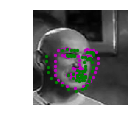

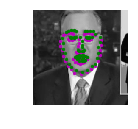

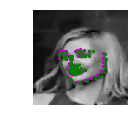

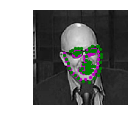

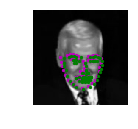

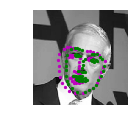

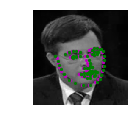

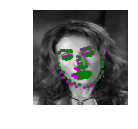

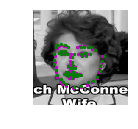

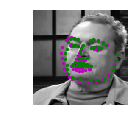

In [26]:



visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [29]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'my_final_model.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: It was a regression task so i chose mean squared error(MSE) as a loss function instead of Cross-Entropy Loss which would be good fit for classification task. MSE squaring of the difference of prediction and actual value means that we’re amplifying large losses so it penalize large loss and ignore or does not enough penalize when network generate small loss.

I use adam optimizer because Adam is a replacement optimization algorithm for stochastic gradient descent , in this A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds unlike sgd .

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with NaimishNet . 
first i increase the size of output features in each conv layer with stride 1 which leads to very large number of input size upon flatten operation, for minimizing that parameter i had to take stride of 2 in some conv layer.

to avoid overfitting i introduce dropout layer same as NaimishNet but with p value not more than 0.4 unlike NaimishNet .

unlike NaimishNet i used batchnorm layers to speedup training otherwise i had to use more number of epoch which would take more time.

unlike NaimishNet i took large kernel size because on training it was giving better result.


### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I chose number of epoch randomly at first, as we can see 30 epoch was sufficient beacuse after 26, 27th epoch the loss converges and not decreasing that much .

I find batch size = 10 is good . In each epoch the weight were updating around 320 times . 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.06021741 -0.08224467 -0.22784466  0.03037542 -0.15394567]
 [-0.22073631 -0.22825526 -0.18368921 -0.01073195  0.12066042]
 [ 0.01945869  0.0932197  -0.11935762 -0.09752311  0.17812763]
 [ 0.20591092 -0.09420928  0.18886867 -0.07336069  0.19604006]
 [ 0.26277044 -0.07179317 -0.0357881  -0.04762175  0.22663094]]
(5, 5)


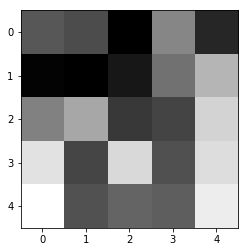

In [27]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

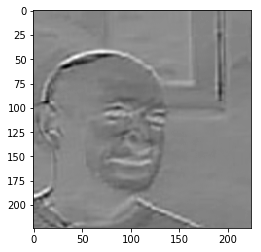

In [65]:
##TODO: load in and display any image from the transformed test dataset
import cv2
img = test_images[0].data.numpy()
img = np.transpose(img, (1, 2, 0))
img = np.squeeze(img)
plt.imshow(img)

weights1 = net.conv1.weight.data
w = weights1.numpy()
filter_index = 0
filterr = w[filter_index][0]

filterd_img = cv2.filter2D(img, -1, filterr)
plt.imshow(filterd_img,cmap = 'gray')
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: I think it blurs out noise.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!